In [1]:
# ===============================
# 0) Import libraries
# ===============================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score

sns.set(style="whitegrid", font_scale=1.0)

In [2]:
# ===============================
# 1) Load dataset
# ===============================
file_path = r"C:\Users\sudha\Downloads\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"

if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")

data = pd.read_csv(file_path)
print("Raw shape:", data.shape)

Raw shape: (225745, 79)


In [3]:
# Identify label column (commonly 'Label')
label_col = [col for col in data.columns if 'Label' in col][0]

# Keep only numeric columns
X = data.drop(columns=[label_col]).select_dtypes(include=[np.number])

In [4]:
# Drop NaNs/Infs
data_clean = data.replace([np.inf, -np.inf], np.nan).dropna()
X = data_clean.select_dtypes(include=[np.number])
y = data_clean[label_col]

# Encode labels: 0 = normal, 1 = attack
y = y.apply(lambda v: 0 if "BENIGN" in v.upper() else 1).astype(int)

print("After cleaning:", X.shape, "| Normal:", (y==0).sum(), "| Attack:", (y==1).sum())

After cleaning: (225711, 78) | Normal: 97686 | Attack: 128025


In [5]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ===============================
# 3) Dimensionality Reduction (PCA)
# ===============================
pca = PCA(n_components=20, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("Reduced feature dimension:", X_pca.shape[1])

Reduced feature dimension: 20


In [6]:
# ===============================
# 4) Model Selection (AIC/BIC on subsample)
# ===============================
sample_size = min(10000, len(X_pca))
idx = np.random.choice(len(X_pca), sample_size, replace=False)
X_subset = X_pca[idx]

bic_vals, aic_vals = [], []
min_k, max_k = 1, 10

print("\nRunning AIC/BIC model selection...")
for k in range(min_k, max_k + 1):
    gm = GaussianMixture(
        n_components=k, covariance_type="diag",
        reg_covar=1e-6, max_iter=100, tol=1e-3, random_state=42
    ).fit(X_subset)
    bic_vals.append(gm.bic(X_subset))
    aic_vals.append(gm.aic(X_subset))
    print(f"K={k}: BIC={bic_vals[-1]:.2f}, AIC={aic_vals[-1]:.2f}")

best_k_bic = np.argmin(bic_vals) + min_k
best_k_aic = np.argmin(aic_vals) + min_k
print(f"\n✅ Best K by BIC: {best_k_bic}, Best K by AIC: {best_k_aic}")


Running AIC/BIC model selection...
K=1: BIC=635616.55, AIC=635328.14
K=2: BIC=426847.01, AIC=426262.97
K=3: BIC=297951.00, AIC=297071.33
K=4: BIC=293203.56, AIC=292028.28
K=5: BIC=53335.49, AIC=51864.58
K=6: BIC=36668.66, AIC=34902.13
K=7: BIC=49470.27, AIC=47408.11
K=8: BIC=21351.65, AIC=18993.86
K=9: BIC=1803.13, AIC=-850.28
K=10: BIC=-19511.66, AIC=-22460.69

✅ Best K by BIC: 10, Best K by AIC: 10


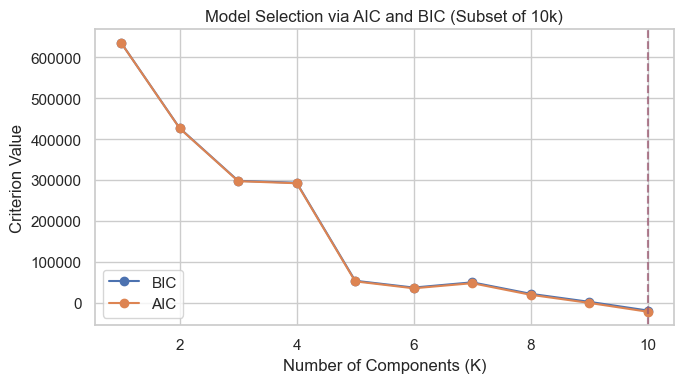

In [7]:
# Plot AIC/BIC curves
plt.figure(figsize=(7,4))
ks = range(min_k, max_k + 1)
plt.plot(ks, bic_vals, marker='o', label='BIC')
plt.plot(ks, aic_vals, marker='o', label='AIC')
plt.axvline(best_k_bic, color='b', linestyle='--', alpha=0.5)
plt.axvline(best_k_aic, color='r', linestyle='--', alpha=0.5)
plt.xlabel("Number of Components (K)")
plt.ylabel("Criterion Value")
plt.title("Model Selection via AIC and BIC (Subset of 10k)")
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# ===============================
# 5) Fit Final GMM Model
# ===============================
K = best_k_bic
print(f"\nTraining final GMM with K={K}...")
gmm = GaussianMixture(
    n_components=K, covariance_type="diag",
    reg_covar=1e-6, max_iter=200, tol=1e-3, random_state=42
)
gmm.fit(X_pca)

# Compute log-likelihood for each sample
log_probs = gmm.score_samples(X_pca)


Training final GMM with K=10...


In [9]:
# ===============================
# 6) Anomaly Detection (threshold)
# ===============================
percentile = 5
threshold = np.percentile(log_probs, percentile)
y_pred = (log_probs < threshold).astype(int)

print(f"\nThreshold at {percentile}th percentile: {threshold:.4f}")
print(f"Detected anomalies: {(y_pred==1).sum()} / {len(y_pred)}")



Threshold at 5th percentile: -39.5793
Detected anomalies: 11286 / 225711


In [10]:
# ===============================
# 7) Evaluation
# ===============================
cm = confusion_matrix(y, y_pred)
report = classification_report(y, y_pred, target_names=["Normal", "Attack"])
acc = np.trace(cm) / cm.sum()

print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)
print(f"Model Accuracy: {acc:.2%}")


Confusion Matrix:
 [[ 86797  10889]
 [127628    397]]

Classification Report:
               precision    recall  f1-score   support

      Normal       0.40      0.89      0.56     97686
      Attack       0.04      0.00      0.01    128025

    accuracy                           0.39    225711
   macro avg       0.22      0.45      0.28    225711
weighted avg       0.20      0.39      0.24    225711

Model Accuracy: 38.63%


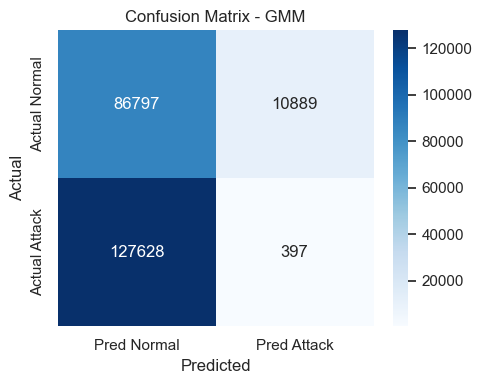

In [11]:
# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred Normal", "Pred Attack"],
            yticklabels=["Actual Normal", "Actual Attack"])
plt.title("Confusion Matrix - GMM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

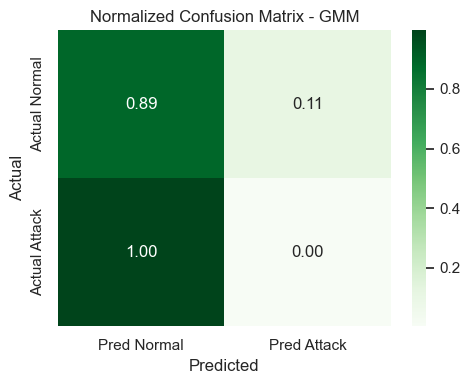

In [12]:
# Normalized confusion matrix
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(5,4))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=["Pred Normal", "Pred Attack"],
            yticklabels=["Actual Normal", "Actual Attack"])
plt.title("Normalized Confusion Matrix - GMM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [13]:
# ===============================
# 8) Silhouette (optional)
# ===============================
try:
    cluster_labels = gmm.predict(X_pca)
    sil = silhouette_score(X_pca, cluster_labels)
    print(f"\nSilhouette Score: {sil:.4f}")
except Exception as e:
    print("Silhouette score skipped:", e)


Silhouette Score: 0.3913



Running t-SNE visualization...


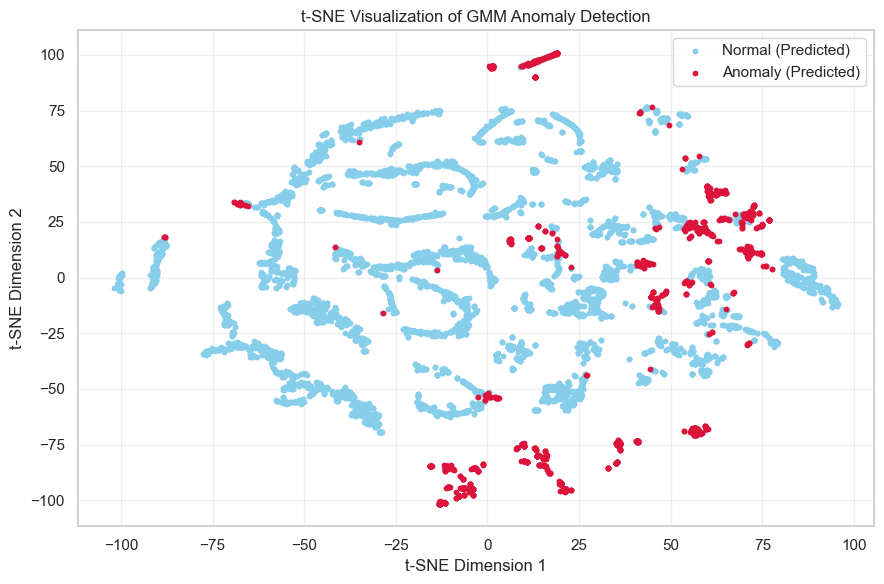

In [14]:
# ===============================
# 9) t-SNE Visualization (Reduced sample)
# ===============================
print("\nRunning t-SNE visualization...")
sample_vis = min(8000, len(X_pca))
X_vis = X_pca[:sample_vis]
y_vis = y_pred[:sample_vis]

tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_embedded = tsne.fit_transform(X_vis)

plt.figure(figsize=(9,6))
plt.scatter(
    X_embedded[y_vis == 0, 0], X_embedded[y_vis == 0, 1],
    s=10, c="skyblue", label="Normal (Predicted)"
)
plt.scatter(
    X_embedded[y_vis == 1, 0], X_embedded[y_vis == 1, 1],
    s=10, c="crimson", label="Anomaly (Predicted)"
)
plt.title("t-SNE Visualization of GMM Anomaly Detection", fontsize=12)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
# ===============================
# 10) Report Notes
# ===============================
print("\n=== REPORT SUMMARY ===")
print(f"- Dataset: CICIDS2017 (Friday Working Hours - DDoS subset)")
print(f"- Features used: {X.shape[1]} numeric features")
print(f"- Selected K (BIC): {K}")
print(f"- Covariance type: diag (faster)")
print(f"- Threshold: bottom {percentile}% log-likelihood for anomalies")
print(f"- Model Accuracy: {acc:.2%}")
print(f"- t-SNE sample size: {sample_vis}")
print("- All features scaled (StandardScaler) and reduced (PCA=20).")
print("- Evaluated using Confusion Matrix, F1-score, and visual analysis.")


=== REPORT SUMMARY ===
- Dataset: CICIDS2017 (Friday Working Hours - DDoS subset)
- Features used: 78 numeric features
- Selected K (BIC): 10
- Covariance type: diag (faster)
- Threshold: bottom 5% log-likelihood for anomalies
- Model Accuracy: 38.63%
- t-SNE sample size: 8000
- All features scaled (StandardScaler) and reduced (PCA=20).
- Evaluated using Confusion Matrix, F1-score, and visual analysis.
